100%|████████████████████████████████████████████| 170498071/170498071 [00:30<00:00, 5560298.05it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


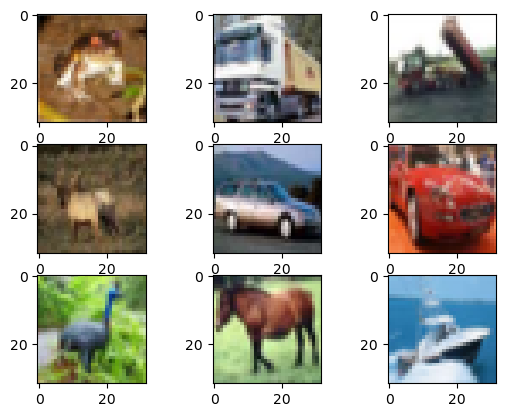

In [1]:
import matplotlib.pyplot as plt

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

# ❶ CIFAR10 데이터셋을 불러옴
training_data = CIFAR10(
    root="./", 
    train=True, 
    download=True, 
    transform=ToTensor())

test_data = CIFAR10(
    root="./", 
    train=False, 
    download=True, 
    transform=ToTensor())

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(training_data.data[i])
plt.show()

In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

Files already downloaded and verified
Files already downloaded and verified


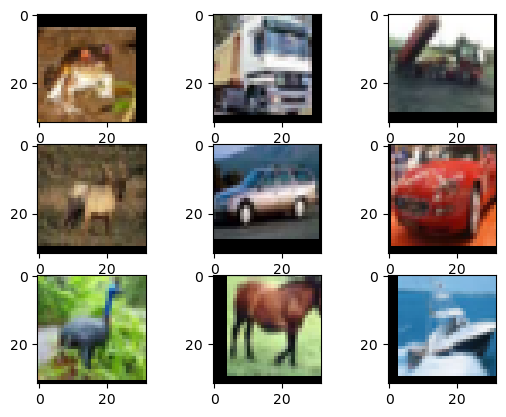

In [4]:
transforms = Compose([
    T.ToPILImage(),
    RandomCrop((32, 32), padding=4),
    RandomHorizontalFlip(p=0.5),
])

training_data = CIFAR10(
    root="./", 
    train=True, 
    download=True, 
    transform=transforms) # transform에는 데이터를 변환하는 함수가 들어감

test_data = CIFAR10(
    root="./", 
    train=False, 
    download=True, 
    transform=transforms)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(transforms(training_data.data[i]))
plt.show()